In [33]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Set, Tuple
import pandas as pd
from itertools import chain

In [62]:
data_type = [('coordinate', '2i'), ('label', 'U1')]

def generate_random_data(low: int, high: int, size: int, label_space: List[str]) -> np.ndarray:
    """
    Generates a structured array of random points and corresponding labels. 
    """

    low = -max(abs(low), abs(high))
    high = max(abs(low), abs(high))

    # Create an empty structured array
    random_data_points = np.empty(size, dtype=data_type)

    # Generate and assign random coordinates 
    random_x = rng.integers(low, high, size)
    random_y = rng.integers(low, high, size)
    random_data_points['coordinate'] = np.column_stack((random_x, random_y))

    # Generate and assign random labels
    random_data_points['label'] = np.random.choice(label_space, size=size)

    return random_data_points

def generate_fixed_data(coordinates: np.ndarray, labels: np.ndarray) -> np.ndarray:
    fixed_data_points = np.empty(shape=len(coordinates), dtype=data_type)

    fixed_data_points['coordinate'] = coordinates

    fixed_data_points['label'] = labels

    return fixed_data_points 

def distance(arr):
    return np.sqrt(arr[0]**2 + arr[1]**2);

np.random.seed(42)
rng = np.random.default_rng()  
low = 1
high = rng.integers(low + 1, 20)
size = rng.integers(low, 20)
label_space = ['A', 'B', 'C', 'D', 'E', 'F']

In [63]:
"""
Generate Points and convert the generated points into a Pandas data DataFrame
"""
points = generate_random_data(-20,20,20, label_space = ['A', 'B', 'C', 'D', 'E', 'F'])
structured_array = np.array(points, dtype=data_type)

#Create a data frame splitting coordinates from the label.
df = pd.DataFrame(structured_array.tolist(), columns=['coordinate', 'label'])

# Split coordinates into x and y columns
df[['x', 'y']] = pd.DataFrame(df['coordinate'].tolist(), index=df.index)

# Drop the original 'coordinates' column
original_data_points = df.drop('coordinate', axis=1)
original_data_points

,label,x,y
0,D,7,2
1,E,-9,1
2,C,16,13
3,E,-11,17
4,E,17,-13
5,B,-4,-17
6,C,-4,13
7,C,-4,-16
8,C,11,-17
9,E,-7,-9


In [67]:
def find_smallest_and_largest_distances(df):

    """
    The function defined below should calculate the radius that we want to graph the correct circle. 
    We take in the dataframe of the points that we generate to return a radius. 
    """

    # Calculate distances for each row
    df['distance'] = df.apply(lambda row: np.sqrt(row['x']**2 + row['y']**2), axis=1)

    # Create separate tables for each label group
    label_groups = df.groupby('label')

    # Dictionary to store individual DataFrames for each label
    label_dataframes = {}

    # Iterate over label groups and create separate DataFrames sorting each by ascending distance.
    for label, group_df in label_groups:
        sorted_df = group_df.sort_values(by='distance', ascending=True)
        label_dataframes[label] = sorted_df.copy()
    

    # Create a new DataFrame "smallest_grouped_distances" which contains all the smallest distances among each label group.
    smallest_grouped_distances = pd.DataFrame(columns=['distance', 'label'])

    # Populate "smallest_grouped_distances" by iterating through each table and taking the first row, 
    #removing the first row from each label table.
    for label, label_df in label_dataframes.items():
        if not label_df.empty: 
            first_row = label_df.iloc[0]
            smallest_grouped_distances = smallest_grouped_distances.append({
                'distance': first_row['distance'],
                'label': first_row['label']
            }, ignore_index=True)
            label_dataframes[label] = label_dataframes[label].iloc[1:].copy()
    
    # Sort smallest_grouped_distances by ascending distance
    smallest_grouped_distances = smallest_grouped_distances.sort_values(by='distance', ascending=True)


#------------------------------------------------------------------------------------------------------------------------
    # Check if there is any duplicate distance, if there is, return the smallest amongst the duplicates.
    if smallest_grouped_distances.duplicated('distance').any():
        return smallest_grouped_distances['distance'].min()

    print("Table of smallest distances among each group: ")
    print(smallest_grouped_distances)

    # Start checking from the second smallest distance.
    for i in range(1, len(smallest_grouped_distances)):
        print()
        print(f"Iteration {i}")

        nth_smallest_distance = smallest_grouped_distances['distance'].astype(float).iloc[i]
        nth_smallest_label = smallest_grouped_distances['label'].iloc[i]

        print(f"The {i+1} smallest distance: ( Distance: {nth_smallest_distance}, Label: {nth_smallest_label}) ")

        # Check if there is a lower distance in other label tables.
        for other_label in label_dataframes.keys():
            
            if other_label != nth_smallest_label:
                lower_distance = label_dataframes[other_label]['distance'].min()
                print(f"Searching {other_label} . . . ")
                print(f"Lowest distance in group {other_label}: {lower_distance}")
                #identify if there exists a lower distance amongst the other groups.
                if lower_distance < nth_smallest_distance:
                    print()
                    print(f"A distance that is lower than the {i} smallest distance among label groups is found: (Distance: {lower_distance}, Label: {other_label})")
                    
                    #identify if that lower distance encapsulates another point from the current label group
                    if lower_distance > label_dataframes[label]['distance'].min():
                        print(f"The lower distance encapsulates another point from {nth_smallest_label} group, thus largest possible distance is {i-2} smallest distance.")
                        return smallest_grouped_distances['distance'].astype(float).iloc[i-2]
                    
                    #if it doesn't encapsulate a lower distance from that label group, it must be the largest possible radius
                    else: 
                        print(f"This means that {i} smallest distance is invalid and will encapsulate another label from another group.")
                        return smallest_grouped_distances['distance'].astype(float).iloc[i-1]

    # If no lower distance found, return the largest amongst the smallest
    return 1 #smallest_grouped_distances['distance'].max()


result = find_smallest_and_largest_distances(original_data_points)

print()
print("Radius of the circle: ", result)

Table of smallest distances among each group: 
    distance label
1   5.000000     C
2   7.280110     D
3   9.055385     E
0  11.704700     B
4  14.212670     F

Iteration 1
The 2 smallest distance: ( Distance: 7.280109889280518, Label: D) 
Searching B . . . 
Lowest distance in group B: 16.278820596099706
Searching C . . . 
Lowest distance in group C: 13.601470508735444
Searching E . . . 
Lowest distance in group E: 11.40175425099138
Searching F . . . 
Lowest distance in group F: 14.317821063276353

Iteration 2
The 3 smallest distance: ( Distance: 9.055385138137417, Label: E) 
Searching B . . . 
Lowest distance in group B: 16.278820596099706
Searching C . . . 
Lowest distance in group C: 13.601470508735444
Searching D . . . 
Lowest distance in group D: 10.44030650891055
Searching F . . . 
Lowest distance in group F: 14.317821063276353

Iteration 3
The 4 smallest distance: ( Distance: 11.704699910719626, Label: B) 
Searching C . . . 
Lowest distance in group C: 13.601470508735444
Search

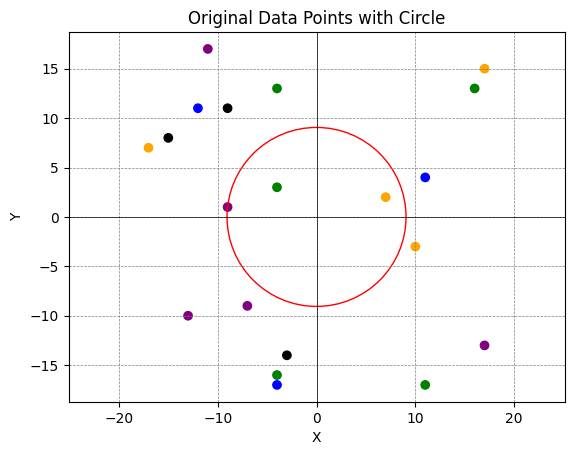

In [68]:
""""
Creating a visualization to confirm that the circl is correct.
"""

color_dict = {'A': 'red', 'B': 'blue', 'C': 'green', 'D': 'orange', 'E': 'purple', 'F': 'black'}

# Plot original data points with correct colors
plt.scatter(original_data_points['x'], original_data_points['y'], c=original_data_points['label'].map(color_dict), label='Data Points')

# Draw a circle based on the result from the previous function
circle = plt.Circle((0, 0), radius=result, edgecolor='red', facecolor='none', label='Circle with Radius from Function')
plt.gca().add_patch(circle)

# Set plot parameters
plt.title('Original Data Points with Circle')
plt.xlabel('X')
plt.ylabel('Y')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.axis('equal')

# Show plot
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a35df759-56fd-4013-8f24-1ee96dffc06c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>